In [12]:
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 221 µs (started: 2023-02-28 13:00:50 -05:00)


### Imports

In [13]:
# import numpy as np
import matplotlib.pyplot as plt  # required for plotting

import json
import pennylane as qml
import pennylane.numpy as np

import jax
import networkx as nx

from functools import partial

from pennylane.templates import ApproxTimeEvolution

from collections import Counter
import math
import importlib
import pickle
import os


from scipy.spatial.distance import jensenshannon

time: 382 µs (started: 2023-02-28 13:00:50 -05:00)


In [15]:
qml.version()

'0.27.0'

time: 1.52 ms (started: 2023-02-28 13:00:51 -05:00)


In [28]:
import utils
utils = importlib.reload(utils)
from utils import *

time: 3.02 ms (started: 2023-03-01 09:32:52 -05:00)


In [17]:
import sys
# check using the right virtual environment
sys.prefix

'/Users/yan/Repositories/qhack23_rydberg_graph/venv'

time: 1.49 ms (started: 2023-02-28 13:00:51 -05:00)


## Construct hamiltonian demo (simple graph example)

### run simulations for different time steps on SV1

In [18]:
### run the simulation for all graphs
n_max = 12
Gs = pickle.load(open(f'Datasets/PTC_graphs_max_{n_max}_nodes.p', 'rb'))
# build hamiltonians for all
# units for hbar = 1
omega = np.pi * 1e6  # rad / sec
delta = 0.7 * omega
hamiltonians = []
for graph in Gs:  
    hamiltonian_rydberg = build_hamiltonian(graph, omega, delta)
    hamiltonians.append(hamiltonian_rydberg)


time: 57.8 ms (started: 2023-02-28 13:00:51 -05:00)


In [19]:
my_bucket = "amazon-braket-us-west-1-880812766447"  # the name of the bucket, keep the 'amazon-braket-' prefix and then include the bucket name
my_prefix = "QEK_sv1_demo"  # the name of the folder in the bucket
s3_folder = (my_bucket, my_prefix)

device_arn = "arn:aws:braket:::device/quantum-simulator/amazon/sv1"

time: 254 µs (started: 2023-02-28 13:00:51 -05:00)


In [20]:
n_wires = n_max
# n_wires = len(n_nodes)
wires = range(n_wires)
shots = 6000

# dev = qml.device('default.qubit', wires=n_wires, shots=shots)
dev_remote = qml.device(
    "braket.aws.qubit",
    device_arn=device_arn,
    wires=n_wires,
    s3_destination_folder=s3_folder,
    shots=shots,
    parallel=True,
)


@qml.qnode(dev_remote)
def circuit(time, hamiltonian, n_trotter_steps=100):
    ApproxTimeEvolution(hamiltonian, time, n_trotter_steps)
    return qml.probs(wires=wires)

time: 752 ms (started: 2023-02-28 13:00:51 -05:00)


In [21]:
my_probs = circuit(1e-6, hamiltonians[0], 5)

time: 5.54 s (started: 2023-02-28 13:00:52 -05:00)


In [22]:
t_range = np.linspace(1e-8, 5.*1e-6, 100)
my_nodesB = [0, 1, 4, 5]
n_prob_list = []
n_expectationB_list = []
n_expectationC_list = []

results = []
# run simulation for different drive durations
for t_max in t_range:
    counts_results_graphs = []
    for hamiltonian in hamiltonians:
        n_trotter_steps = math.floor(t_max * 1e6) * 500 + 1
        # print(n_trotter_steps)
        counts_results = circuit(t_max, hamiltonian, n_trotter_steps)
        # print(counts_results)
        counts_results_graphs.append(counts_results)    
    results.append(counts_results_graphs)

KeyboardInterrupt: 

time: 20h 29min 24s (started: 2023-02-28 13:00:58 -05:00)


In [23]:
filename = f'results_pennylane_sv1_{n_max}.p'

if not os.path.isdir('results_QEK/'):
    os.mkdir('results_QEK/')
with open("results_QEK/"+filename, 'wb') as f:
    f.write(pickle.dumps(results))


time: 86.6 ms (started: 2023-03-01 09:30:56 -05:00)


In [37]:
t_range = t_range[:len(results)]

time: 178 µs (started: 2023-03-01 17:08:50 -05:00)


In [31]:
from utils import *

time: 205 µs (started: 2023-03-01 09:33:53 -05:00)


In [34]:
# the results are probabilities, convert to counts
new_results = [[_convert_to_counts(result_graph, n_wires) for result_graph in results_graph]for results_graph in results]

time: 2min 47s (started: 2023-03-01 09:34:16 -05:00)


In [35]:

kernel_counts_fn = partial(outcome_counts, shots=shots)
kernels = []
for t_max, counts_graph in zip(t_range, new_results): # loop over different drive durations
    # counts_graph = [get_counts(result_graph) for result_graph in results_graph] # get state counts from simulator result
    # counts_graph = [get_counts(result) for result in results] # get state counts from simulator result
    kernel_t = compute_kernel(counts_graph, kernel_counts_fn) # compute kernel matrix
    kernels.append(kernel_t)
kernels = np.stack(kernels)

/Users/yan/Repositories/qhack23_rydberg_graph/venv/lib/python3.9/site-packages/scipy/spatial/distance.py:1300: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)


time: 32min 35s (started: 2023-03-01 12:02:30 -05:00)


In [42]:
filename = f'kernels_pennylane_sv1_{n_max}.p'

if not os.path.isdir('results_QEK/'):
    os.mkdir('results_QEK/')
with open("results_QEK/"+filename, 'wb') as f:
    f.write(pickle.dumps(kernels))


time: 32.8 ms (started: 2023-03-01 17:33:32 -05:00)


Text(0, 0.5, 'Jensen-Shannon divergence $JS(P1, P2)$')

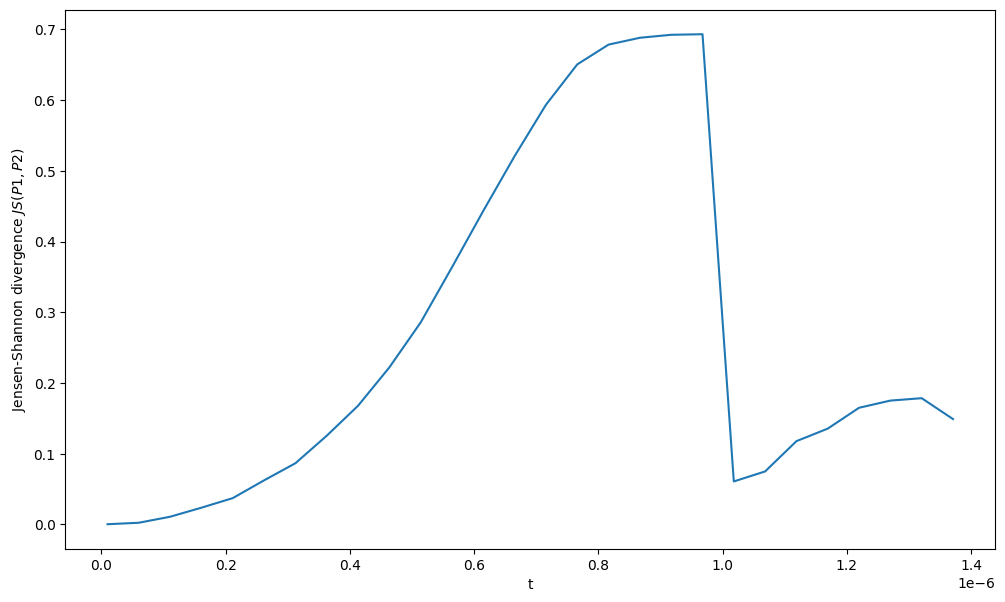

time: 102 ms (started: 2023-03-01 17:33:38 -05:00)


In [43]:
fig, axes = plt.subplots(1, 1, figsize=(12, 7))
axes.plot(t_range, (- np.log(kernels[:, 0, 1]))**2, label='kernel')
axes.set_xlabel('t')
axes.set_ylabel(r'Jensen-Shannon divergence $JS(P1, P2)$')

In [44]:
outcome_fn = partial(get_expectations_nodes, shots=shots, averaged_nodes=my_nodesB)
outcomes = []
for t_max, counts_graph in zip(t_range, new_results): # loop over different drive durations
    # counts_graph = [get_counts(result_graph) for result_graph in results_graph] # get state counts from simulator result
    outcomes_t = compute_outcomes(counts_graph, outcome_fn) # compute kernel matrix
    # print(outcomes_t.shape)
    outcomes.append(outcomes_t)
outcomes = np.stack(outcomes)    

Text(0.5, 0, 'Drive duration [s]')

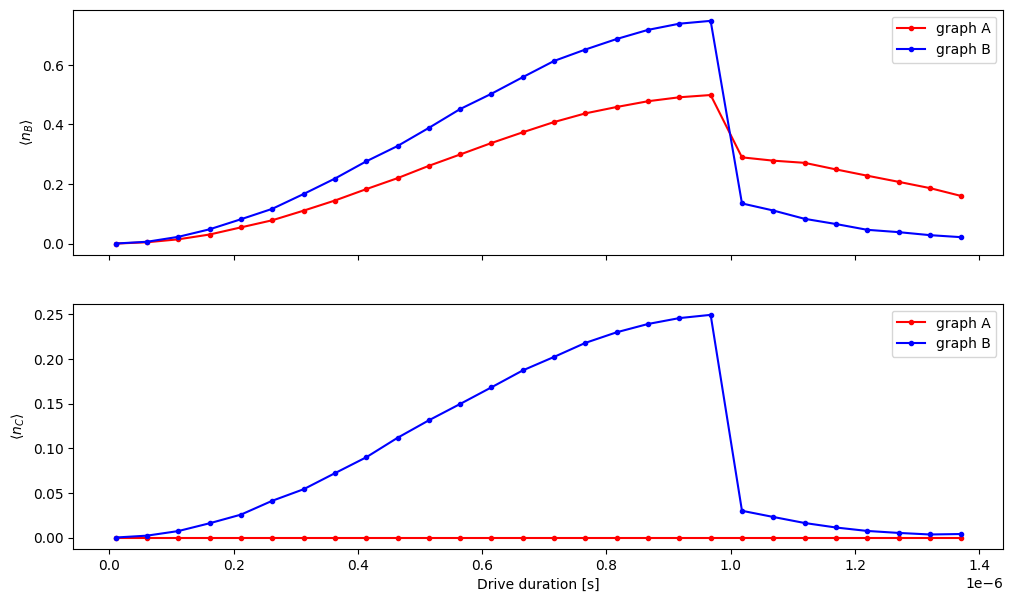

time: 153 ms (started: 2023-03-01 17:10:13 -05:00)


In [40]:
fig, axes = plt.subplots(2, 1, figsize=(12, 7), sharex=True)
y_labels = [r'$\langle n_B \rangle$', r'$\langle n_C \rangle$']
labels = ['B', 'C']
colors = ['r', 'b']
labels_graph = ['A', 'B']
for i, ylabel in enumerate(y_labels):
    ax = axes[i]
    for j in range(2):
        ax.plot(t_range, outcomes[:, j, i], '.-', label=f"graph {labels_graph[j]}", color=colors[j])
    ax.set_ylabel(ylabel)
    ax.legend()

plt.xlabel('Drive duration [s]')
# plt.legend()
# plt.ylabel(r'$\langle n \rangle$')

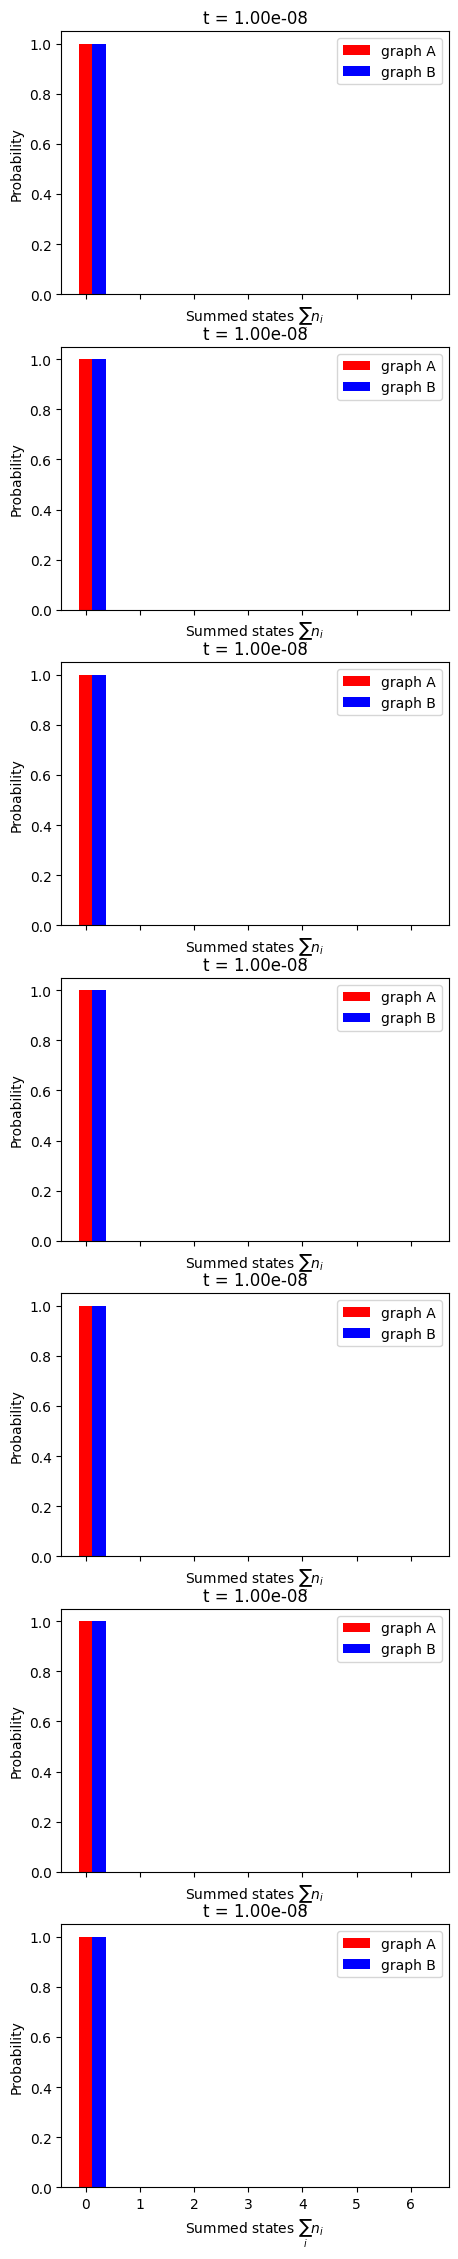

time: 557 ms (started: 2023-02-28 12:34:03 -05:00)


In [ ]:
t_list = [0.1e-6, 0.25e-6, 0.57e-6, 0.924e-6, 1.04e-6, 1.2e-6, 2.5e-6]
barWidth = 0.25
br1 = np.arange(len(graphA_nodes)+1)
br2 = [x + barWidth for x in br1]
bars = [br1, br2]
colors = ['r', 'b']
labels = ['graph A', 'graph B']
# plot the probability distribution for different drive durations as a function of summed states
fig, axes = plt.subplots(len(t_list), 1, figsize=(5, 4 * len(t_list)), sharex=True)
for t, ax in zip(t_list, axes):
    # idx = np.where(t_range == t)[0][0] # get index of t
    idx = np.argmin(np.abs(t_range - t))
    probabilities = []
    
    for i in range(2):
        counts_graph = new_results[idx][i]
        p = get_counts_summed_probabilities(counts_graph, shots=shots)
        probabilities.append(p)
        # print(p)

        ax.bar(bars[i], p, label=labels[i], width=barWidth, color=colors[i])
        # ax.set_ylim(0, 1)
        ax.set_ylabel("Probability")
        ax.set_xlabel(r"Summed states $\sum_i n_i$")
        ax.legend()
        ax.set_title('t = {:.2e}'.format(t_range[idx]))
    # ax.set_title('t = {:.2e}'.format(t))




### run simulations for different time steps

In [ ]:
### run the simulation for all graphs
n_max = 12
Gs = pickle.load(open(f'Datasets/PTC_graphs_max_{n_max}_nodes.p', 'rb'))
# build hamiltonians for all

# units for hbar = 1
omega = np.pi * 1e6  # rad / sec
delta = 0.7 * omega
hamiltonians = []
for graph in Gs:  
    hamiltonian_rydberg = build_hamiltonian(graph, omega, delta)
    hamiltonians.append(hamiltonian_rydberg)


NameError: name 'pickle' is not defined

In [ ]:
my_bucket = "amazon-braket-us-west-1-880812766447"  # the name of the bucket, keep the 'amazon-braket-' prefix and then include the bucket name
my_prefix = "QEK_sv1"  # the name of the folder in the bucket
s3_folder = (my_bucket, my_prefix)

device_arn = "arn:aws:braket:::device/quantum-simulator/amazon/sv1"

In [ ]:
n_wires = n_max
# n_wires = len(n_nodes)
print(n_wires)
wires = range(n_wires)
shots = 6000

dev = qml.device('default.qubit', wires=n_wires, shots=shots)


@qml.qnode(dev)
def circuit(time, hamiltonian, n_trotter_steps=100):
    ApproxTimeEvolution(hamiltonian, time, n_trotter_steps)
    return qml.probs(wires=wires)

12


NameError: name 'qml' is not defined

In [ ]:
circuit(1, hamiltonians[0], 5)

In [ ]:
n_wires = len(Gs[0].nodes())
# n_wires = len(n_nodes)
wires = range(n_wires)
shots = 6000

# dev = qml.device('default.qubit', wires=n_wires, shots=shots)
dev_remote = qml.device(
    "braket.aws.qubit",
    device_arn=device_arn,
    wires=n_wires,
    s3_destination_folder=s3_folder,
    parallel=True,
)


@qml.qnode(dev_remote)
def circuit(time, hamiltonian, n_trotter_steps=100):
    ApproxTimeEvolution(hamiltonian, time, n_trotter_steps)
    return qml.counts()

In [ ]:
filename = f'results_pennylane_local_qubit_{n_max}.p'

if not os.path.isdir('results_QEK/'):
    os.mkdir('results_QEK/')
with open("results_QEK/"+filename, 'wb') as f:
    f.write(pickle.dumps(results))


time: 17 ms (started: 2023-02-28 00:41:18 -05:00)


In [ ]:

kernel_counts_fn = partial(outcome_counts, shots=shots)
kernels = []
for t_max, counts_graph in zip(t_range, results): # loop over different drive durations
    # counts_graph = [get_counts(result_graph) for result_graph in results_graph] # get state counts from simulator result
    # counts_graph = [get_counts(result) for result in results] # get state counts from simulator result
    kernel_t = compute_kernel(counts_graph, kernel_counts_fn) # compute kernel matrix
    kernels.append(kernel_t)
kernels = np.stack(kernels)

time: 6.37 ms (started: 2023-02-28 00:36:23 -05:00)


Text(0, 0.5, 'Jensen-Shannon divergence $JS(P1, P2)$')

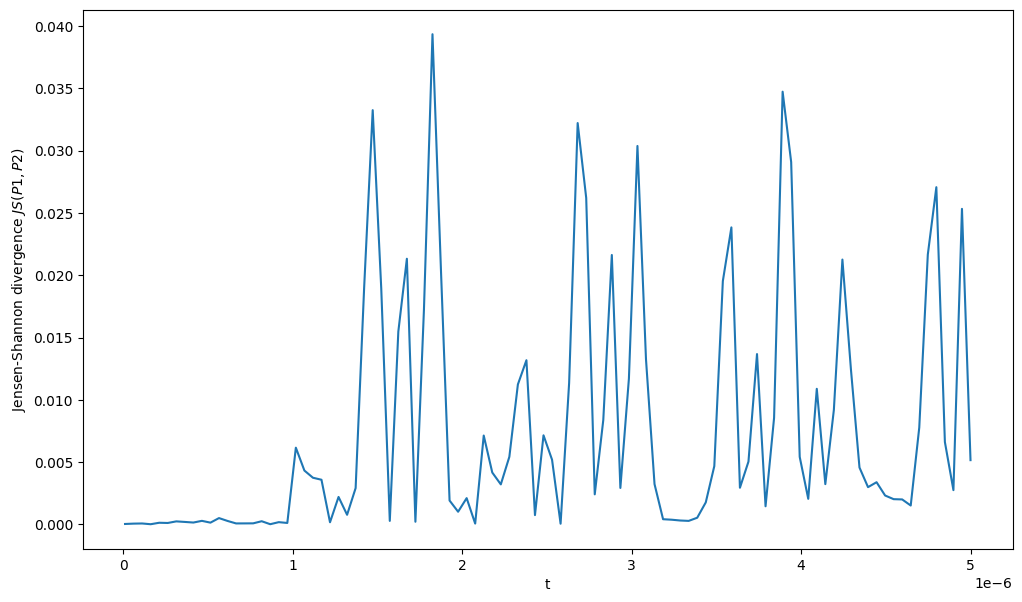

time: 101 ms (started: 2023-02-28 00:36:23 -05:00)


In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(12, 7))
axes.plot(t_range, (- np.log(kernels[:, 0, 1]))**2, label='kernel')
axes.set_xlabel('t')
axes.set_ylabel(r'Jensen-Shannon divergence $JS(P1, P2)$')

In [ ]:
outcome_fn = partial(get_expectations_nodes, shots=shots, averaged_nodes=my_nodesB)
outcomes = []
for t_max, counts_graph in zip(t_range, results): # loop over different drive durations
    # counts_graph = [get_counts(result_graph) for result_graph in results_graph] # get state counts from simulator result
    outcomes_t = compute_outcomes(counts_graph, outcome_fn) # compute kernel matrix
    # print(outcomes_t.shape)
    outcomes.append(outcomes_t)
outcomes = np.stack(outcomes)    

time: 7.8 ms (started: 2023-02-28 00:36:24 -05:00)


Text(0.5, 0, 'Drive duration [s]')

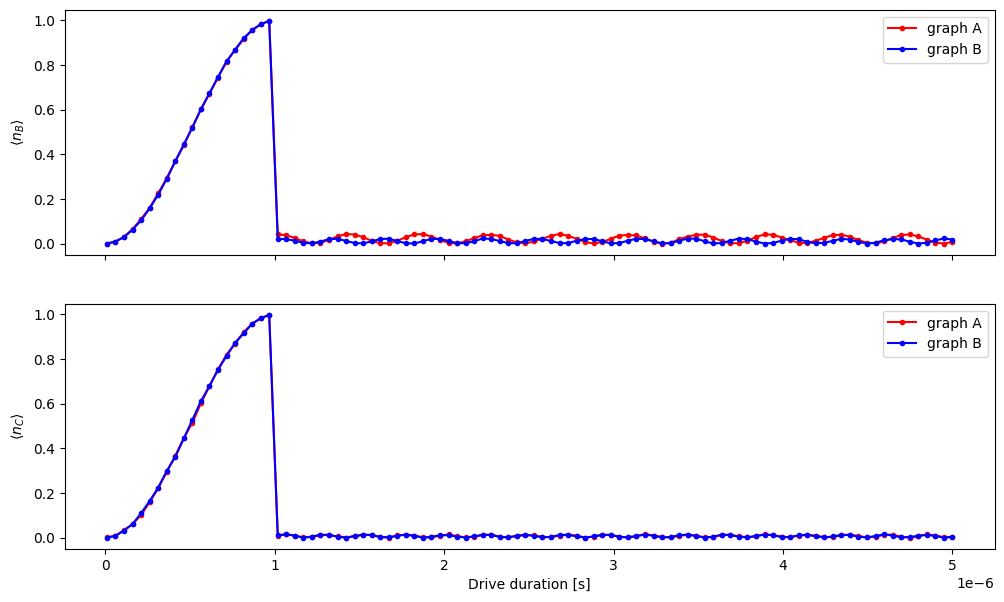

time: 155 ms (started: 2023-02-28 00:36:24 -05:00)


In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(12, 7), sharex=True)
y_labels = [r'$\langle n_B \rangle$', r'$\langle n_C \rangle$']
labels = ['B', 'C']
colors = ['r', 'b']
labels_graph = ['A', 'B']
for i, ylabel in enumerate(y_labels):
    ax = axes[i]
    for j in range(2):
        ax.plot(t_range, outcomes[:, j, i], '.-', label=f"graph {labels_graph[j]}", color=colors[j])
    ax.set_ylabel(ylabel)
    ax.legend()

plt.xlabel('Drive duration [s]')
# plt.legend()
# plt.ylabel(r'$\langle n \rangle$')

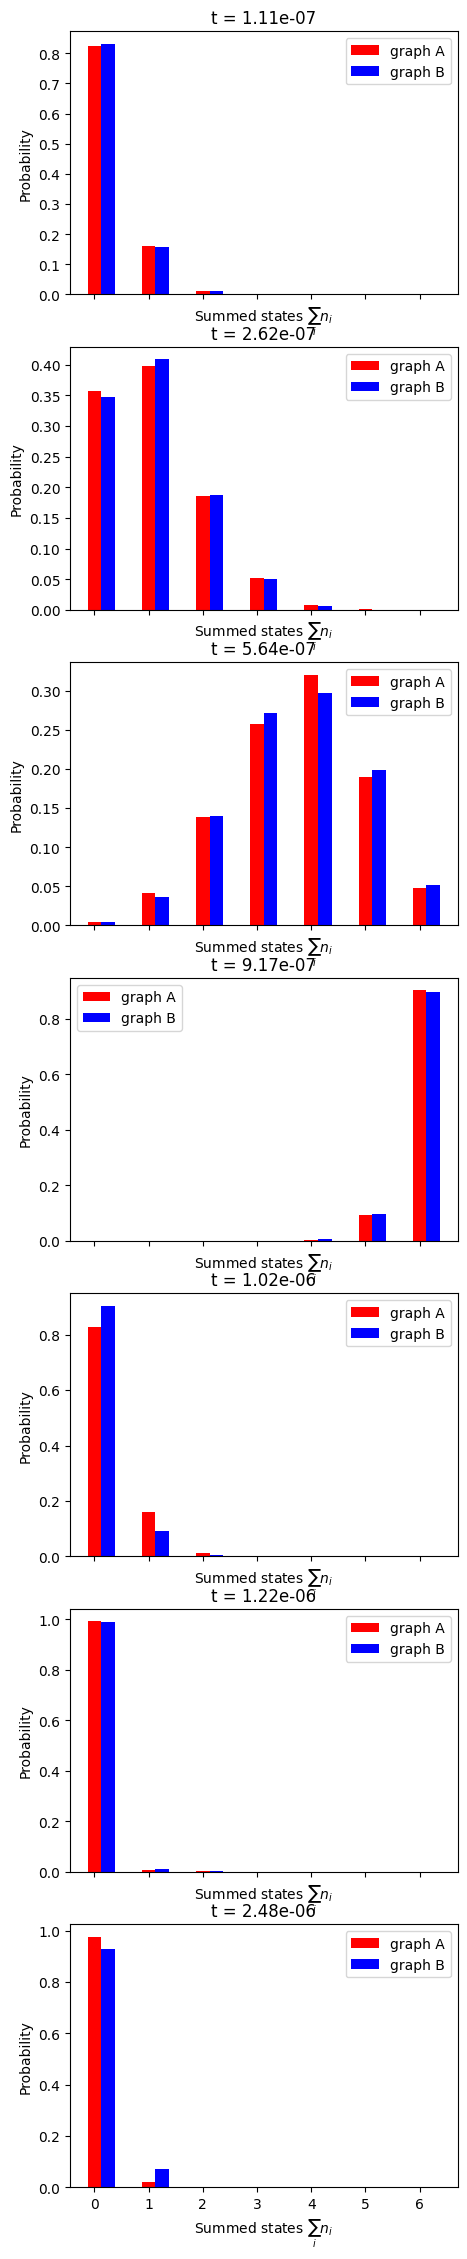

time: 578 ms (started: 2023-02-28 00:36:24 -05:00)


In [ ]:
t_list = [0.1e-6, 0.25e-6, 0.57e-6, 0.924e-6, 1.04e-6, 1.2e-6, 2.5e-6]
barWidth = 0.25
br1 = np.arange(len(graphA_nodes)+1)
br2 = [x + barWidth for x in br1]
bars = [br1, br2]
colors = ['r', 'b']
labels = ['graph A', 'graph B']
# plot the probability distribution for different drive durations as a function of summed states
fig, axes = plt.subplots(len(t_list), 1, figsize=(5, 4 * len(t_list)), sharex=True)
for t, ax in zip(t_list, axes):
    # idx = np.where(t_range == t)[0][0] # get index of t
    idx = np.argmin(np.abs(t_range - t))
    probabilities = []
    
    for i in range(2):
        counts_graph = results[idx][i]
        p = get_counts_summed_probabilities(counts_graph, shots=shots)
        probabilities.append(p)
        # print(p)

        ax.bar(bars[i], p, label=labels[i], width=barWidth, color=colors[i])
        # ax.set_ylim(0, 1)
        ax.set_ylabel("Probability")
        ax.set_xlabel(r"Summed states $\sum_i n_i$")
        ax.legend()
        ax.set_title('t = {:.2e}'.format(t_range[idx]))
    # ax.set_title('t = {:.2e}'.format(t))


